# Лабораторна робота № 3

**Тема.** Кількісний аналіз рекурентних діаграм.

**Мета.** Ознайомитись з кількісними оцінками рекурентних діаграм для аналізу 
динаміки складних систем.

## Теоретичні відомості

Для якісного опису системи графічне представлення системи підходить якнайкраще. Однак головним недоліком графічного представлення є те, що воно змушує користувачів суб'єктивно інтуїтивно інтерпретувати закономірності та структури, представлені на рекурентній діаграмі.

Крім того, зі збільшенням розміру даних, проблематичним представляється аналіз усіх $N^2$ значень. Як наслідок, доводиться працювати з окремими ділянками вихідних даних. Аналіз у такий спосіб може створювати нові дефекти, які спотворюють об'єктивність спостережуваних закономірностей і призводять до неправильних інтерпретацій. Щоб подолати це обмеження і поширити об'єктивну оцінку серед дослідників, на початку 1990-х років Веббером та Збілутом були введені визначення та процедури для кількісної оцінки складності рекурентних діаграм, а згодом вони були розширені Марваном та ін. 

Дрібномасштабні кластери можуть являти собою комбінацію ізольованих точок (випадкових рекурентностей). Подібна еволюція в різні періоди часу або в зворотному часовому порядку представлятиме діагональні лінії (детерміновані структури), а також вертикальні/горизонтальні лінії для позначення ламінарних станів (переривчастість) або станів, що предсталяють сингулярності. Для кількісного опису системи системи такі дрібномасштабні кластери слугують основою кількісного рекурентного аналізу (recurrence quantification analysis, RQA).

## Хід роботи

Перш ніж переходити до опису кожної з мір та розрахунків, визначемось з інструментарієм для виконання RQA. Як і до цього, ми використовуватимемо бібліотеку `neuralkit2`. 

Тепер імпортуємо бібліотеки для подальшої роботи:

In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import neurokit2 as nk
import yfinance as yf
import scienceplots
import pandas as pd
from tqdm import tqdm

%matplotlib inline

І виконаємо налаштування рисунків для виводу:

In [2]:
plt.style.use(['science', 'notebook', 'grid']) # стиль, що використовуватиметься
                                               # для виведення рисунків

params = {
    'figure.figsize': (8, 6),         # встановлюємо ширину та висоту рисунків за замовчуванням
    'font.size': 22,                  # розмір фонтів рисунку
    'lines.linewidth': 2,             # товщина ліній
    'axes.titlesize': 'small',        # розмір титулки над рисунком
    "font.family": "sans-serif",      # сімейство стилів підписів 
    "font.serif": ["Times"],          # стиль підпису
    'savefig.dpi': 300                # якість збережених зображень
}

plt.rcParams.update(params)           # оновлення стилю згідно налаштувань

Розглянемо можливість використання всіх згаданих показників у якості індикаторів або індикаторів-передвісників кризових явищ. Для прикладу завантажимо часовий ряд фондового індексу Доу-Джонса за період з 1 грудня 1993 по 1 грудня 2022, використовуючи `yfinance`:

In [3]:
symbol = '^DJI'          # Символ індексу
start = "1993-01-01"     # Дата початку зчитування даних
end = "2022-01-01"       # Дата закінчення зчитування даних

data = yf.download(symbol, start, end)  # вивантажуємо дані
time_ser = data['Adj Close'].copy()     # зберігаємо саме ціни закриття

xlabel = 'time, days'    # підпис по вісі Ох 
ylabel = symbol          # підпис по вісі Оу

[*********************100%%**********************]  1 of 1 completed


::: {.callout-warning}
## Увага

Виконайте цей блок, якщо хочете зчитати дані не з Yahoo! Finance, а із власного файлу. Зрозуміло, що й аналіз результатів, і висновки залежать від того з яким рядом ми працюємо. 

:::

---

In [ ]:
symbol = 'sMpa11'                  # Символ індексу

path = "databases\sMpa11.txt"      # шлях по якому здійснюється зчитування файлу
data = pd.read_csv(path,           # зчитування даних 
                   names=[symbol])
time_ser = data[symbol].copy()     # копіюємо значення кривої 
                                   # "напруга-видовження" до окремої змінної

xlabel = r'$\varepsilon$'          # підпис по вісі Ох 
ylabel = symbol                    # підпис по вісі Оу

---

Виведемо досліджуваний ряд:

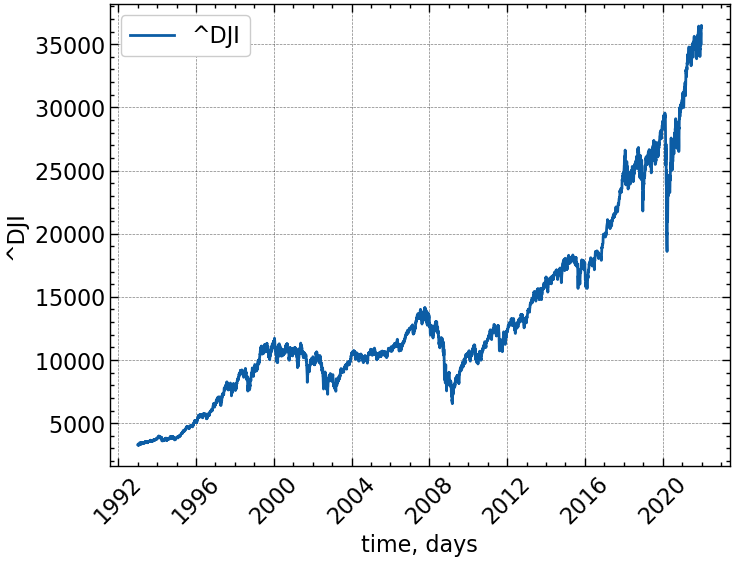

In [4]:
#| label: fig-dji-init 
#| fig-cap: "Динаміка щоденних змін індексу Доу-Джонса"

fig, ax = plt.subplots()                   # Створюємо порожній графік
ax.plot(time_ser.index, time_ser.values)   # Додаємо дані до графіку
ax.legend([symbol])                        # Додаємо легенду
ax.set_xlabel(xlabel)                      # Встановимо підпис по вісі Ох
ax.set_ylabel(ylabel)                      # Встановимо підпис по вісі Oy

plt.xticks(rotation=45)                    # оберт позначок по осі Ох на 45 градусів

plt.savefig(f'{symbol}.jpg')               # Зберігаємо графік 
plt.show();                                # Виводимо графік

Користуючись тими методами, що ми розглянули в попередній лабораторній роботі, побудуємо атрактор даного ряда та його рекурентну діаграму. Але перш за все, треба стандартизувати наш ряд. Для цього оголосимо функцію `transformation()`, що прийматиме на вхід часовий сигнал, тип ряду, і повертатиме його перетворення:

In [5]:
def transformation(signal, ret_type):

    for_rec = signal.copy()

    if ret_type == 1:       # Зважаючи на вид ряду, виконуємо
                            # необхідні перетворення
        pass
    elif ret_type == 2:
        for_rec = for_rec.diff()
    elif ret_type == 3:
        for_rec = for_rec.pct_change()
    elif ret_type == 4:
        for_rec = for_rec.pct_change()
        for_rec -= for_rec.mean()
        for_rec /= for_rec.std()
    elif ret_type == 5: 
        for_rec = for_rec.pct_change()
        for_rec -= for_rec.mean()
        for_rec /= for_rec.std()
        for_rec = for_rec.abs()
    elif ret_type == 6:
        for_rec -= for_rec.mean()
        for_rec /= for_rec.std()

    for_rec = for_rec.dropna().values

    return for_rec

Далі приводимо ряд до стандартизованого вигляду:

In [6]:
signal = time_ser.copy()
ret_type = 6    # вид ряду: 1 - вихідний, 
                # 2 - детрендований (різниця між теп. значенням та попереднім)
                # 3 - прибутковості звичайні, 
                # 4 - стандартизовані прибутковості, 
                # 5 - абсолютні значення (волатильності)
                # 6 - стандартизований ряд

for_rec = transformation(signal, ret_type) 

Для всього ряду і для віконної процедру визначимо наступні параметри:

- розмірність вкладень $m=3$; 
- часова затримка $\tau=1$; 
- радіус багатовимірного околу $\varepsilon = 0.3$. 

Задамо необхідні параметри для обчислення та виводу:

In [7]:
m = 3                         # розмірність вкладень
tau = 1                       # часові затримка
eps = 0.3                     # радіус

І тепер подивимось на фазові траєкторії досліджуваної системи у дво- та тривимірному просторах:

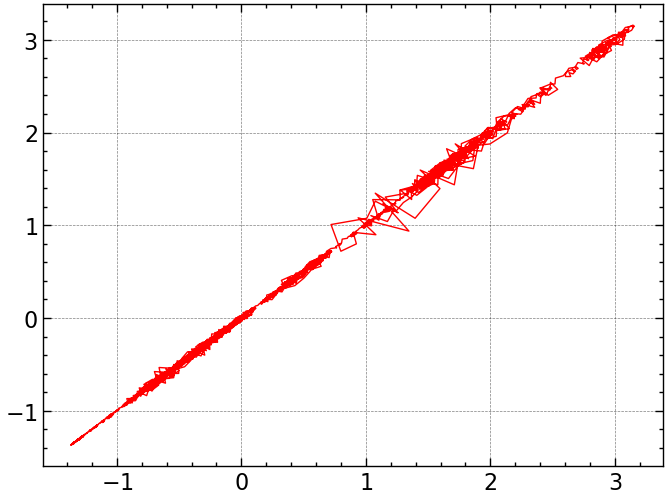

In [8]:
#| label: fig-dji-2d
#| fig-cap: "Двовимірний фазовий портрет стандартизованих
#| вихідних значень досліджуваного ряду Доу-Джонса"

nk.complexity_attractor(nk.complexity_embedding(for_rec, dimension=2, delay=tau), 
                        alpha=1, 
                        color="red"); 

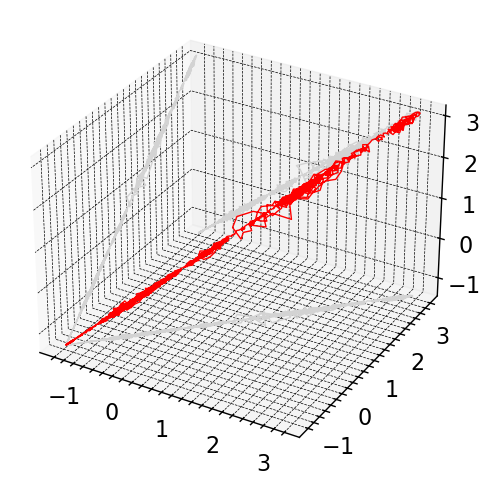

In [9]:
#| label: fig-dji-3d
#| fig-cap: "Тривимірний фазовий портрет стандартизованих
#| вихідних значень досліджуваного ряду Доу-Джонса"

nk.complexity_attractor(nk.complexity_embedding(for_rec, dimension=3, delay=tau), 
                        alpha=1, 
                        color="red"); 

Як можна бачити по візуальному огляду траєкторій у фазовому просторі важко робити висновки стосовно передбачуванності або хаотичності системи. Спробуємо ще раз, але тепер послуговуючись рекурентною діаграмою:

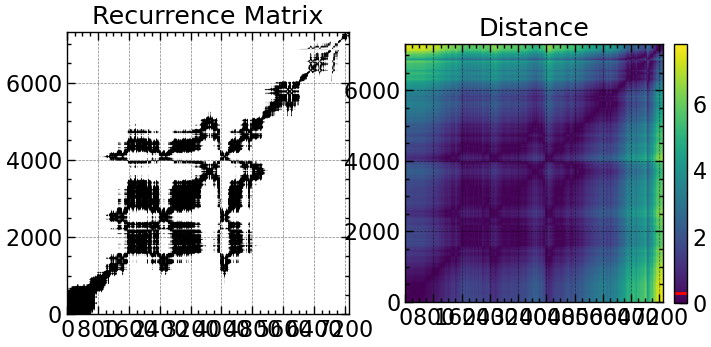

In [10]:
#| label: fig-dji-init-stand
#| fig-cap: "Рекурентна матриця для стандартизованого вихідного ряду Доу-Джонса"

rc, _ = nk.recurrence_matrix(for_rec, 
                            delay=1, 
                            dimension=m,
                            tolerance=eps,
                            show=True)

Як можна бачити, на основі рекурентної діаграми в перспективі ми можемо отримати куди більше інформації стосовно еволюції системи. Видно, що 2000-2008 рік характеризувалися найвищим ступенем самоорганізації (рекурентності) про що свідчать доволі велика щільність чорних областей. У той же час можна бачити, що останні роки характеризуються найменшим ступенем рекурентності. Можливо, прогнозованість подій у межах 2022 року варто було б охарактеризувати за допомогою інших індикаторів, але але рекурентна матриця говорить, що події минулих років мало корелюють з теперішнім.

Ми вже зазначали, що якісна репрезентація рекурентності станів не є достатньо об'єктивною. Найращим варіантом у даному випадку буде використання рекурентного аналізу наряду с алгоритмом рухомого вікна, що використовувався нами у першій лабораторній роботі, і буде використовуватись і надалі. 

### Віконна процедура

Для подальшої роботи створюємо віконну процедуру, в якій знов визначаємо вид ряду та ще декілька параметрів. Потім ми ініціалізуємо масиви для кожної рекурентної міри.

In [11]:
ret_type = 6            # вид ряду
window = 250            # ширина вікна
tstep = 1               # часовий крок вікна 
length = len(time_ser)  # довжина самого ряду

m = 1                   # розмірність вкладень
tau = 1                 # часові затримка
eps = 0.3               # радіус

                        # Ініціалізуємо масиви для збереження віконних значень 
                        # рекурентних мір

RR = []                 # Частота повторення
DET = []                # Детермінізм
DIV = []                # Розбіжність
AVG_DIAG_LINE = []      # Усереднена довжина діагональних ліній
ENT_DIAG = []           # Ентропія діагональних ліній
LAM = []                # Ламінарність
TT = []                 # Час затримки
ENT_VERT = []           # Ентропія вертикальних ліній
ENT_WHITE_VERT = []     # Ентропія білих вертикальних ліній
AVG_WVERT_LINE = []     # Усереднена довжина білих вертикальних ліній
VERT_DIV = []           # Розбіжність вертикальних ліній
RATIO_DET_REC = []      # Відношення детермінізму до частоти повторень
RATIO_LAM_DET = []      # Відношення ламінарності до детермінізму
WHITE_VERT_DIV = []     # Розбіжність білих вертикальних ліній
DIAG_RR = []            # Діагональна частота рекурентних значень

Для подальших розрахунків ми використовуватимемо метод `complexity_rqa()` бібліотеки `neuralkit2`. Синтаксис даного методу виглядає наступним чином:

**`complexity_rqa(signal, dimension=3, delay=1, tolerance='sd', min_linelength=2, method='python', show=False)`**

**Параметри**

- **signal** (*Union[list, np.ndarray, pd.Series]*) --- сигнал (тобто часовий ряд) у вигляді вектора значень.
- **delay** (*int*) --- затримка в часі. 
- **dimension** (*int*) --- розмірність вкладень, $m$. 
- **tolerance** (*float*) --- радіус $\varepsilon$ багатовимірного околу в межах якого шукаються рекурентні траєкторії (часто позначається як $r$), відстань, на якій дві точки даних вважаються схожими. Якщо `"sd"` (за замовчуванням), буде встановлено значення $0.2 \cdot SD_{signal}$.
- **min_linelength** (*int*) --- мінімальна довжина діагональних та вертикальних ліній За замовчування дорівнює 2. 
- **method** (*str*) --- Може бути `"pyrqa"` для виконання рекурентного аналізу, але із використанням бібліотеки `PyRQA` (потребує додаткового встановлення).
- **show** (*bool*) --- візуалізувати рекурентну матрицю.

**Повертає**

- **rqa** (*DataFrame*) --- результати процедури RQA.
- **info** (*dict*) --- словник, що містить інформацію відносно параметрів, що використовувались для виконання RQA. 

Тепер можемо приступити до віконної процедури:

In [12]:
for i in tqdm(range(0,length-window,tstep)):  # фрагменти довжиною window  
                                              # з кроком tstep

    fragm = time_ser.iloc[i:i+window].copy()  # відбираємо фрагмент

    fragm = transformation(fragm, ret_type)   # виконуємо процедуру 
                                              # трансформації ряду
    
    resultRQA, _ = nk.complexity_rqa(fragm,
                                     delay=tau,
                                     dimension=m,
                                     tolerance=eps)
    
    # Обчислення відношення ламінарності до детермінізму
    resultRQA['LamiDet'] = resultRQA['Laminarity']/resultRQA['Determinism']

    # Обчислення дивергенції чорних вертикальних ліній
    resultRQA['VDiv'] = 1./resultRQA['VMax']

    # Обчислення дивергенції білих вертикальних ліній
    resultRQA['WVDiv'] = 1./resultRQA['WMax']

    RR.append(resultRQA['RecurrenceRate'])
    DET.append(resultRQA['Determinism'])
    DIV.append(resultRQA['Divergence']) 
    AVG_DIAG_LINE.append(resultRQA['L'])
    ENT_DIAG.append(resultRQA['LEn'])
    LAM.append(resultRQA['Laminarity']) 
    TT.append(resultRQA['TrappingTime']) 
    ENT_VERT.append(resultRQA['VEn'])
    ENT_WHITE_VERT.append(resultRQA['WEn'])
    AVG_WVERT_LINE.append(resultRQA['W']) 
    VERT_DIV.append(resultRQA['VDiv'])
    WHITE_VERT_DIV.append(resultRQA['WVDiv'])
    RATIO_DET_REC.append(resultRQA['DeteRec']) 
    RATIO_LAM_DET.append(resultRQA['LamiDet'])
    DIAG_RR.append(resultRQA['DiagRec'])

100%|██████████| 7054/7054 [02:39<00:00, 44.16it/s]


Зберігаємо отримані результати в текстових файлах:

In [13]:
name = f"RQA_classic_name={symbol}_window={window}_ \
    step={tstep}_rettype={ret_type}_m={m}_ \
    tau={tau}_eps={eps}.txt"

np.savetxt("RR" + name, RR)
np.savetxt("DIAG_RR" + name, DIAG_RR)
np.savetxt("DET" + name, DET)
np.savetxt("DIV" + name, DIV)
np.savetxt("VERT_DIV" + name, VERT_DIV)
np.savetxt("WHITE_VERT_DIV" + name, WHITE_VERT_DIV)
np.savetxt("LAM" + name, LAM)
np.savetxt("TT" + name, TT)
np.savetxt("AVG_DIAG_LINE" + name, AVG_DIAG_LINE)
np.savetxt("AVG_WRITE_VERT_LINE" + name, AVG_WVERT_LINE)
np.savetxt("ENT_DIAG" + name, ENT_DIAG)
np.savetxt("ENT_VERT" + name, ENT_VERT)
np.savetxt("ENT_WHITE_VERT" + name, ENT_WHITE_VERT)
np.savetxt("RATIO_DET_REC" + name, RATIO_DET_REC)
np.savetxt("RATIO_LAM_DET" + name, RATIO_LAM_DET)

### Рекурентні міри

Тепер займемося побудовою та інтерпретацією отриманих результатів. Для візуалізації графіків визначимо наступну функцію:

In [14]:
def plot_recurrence_measure(measure, label, clr="magenta"):

    fig, ax = plt.subplots()

    ax2 = ax.twinx()

    ax2.spines.right.set_position(("axes", 1.03))

    p1, = ax.plot(time_ser.index[window:length:tstep], 
                  time_ser.values[window:length:tstep], 
                  "b-", label=fr"{ylabel}")
    p2, = ax2.plot(time_ser.index[window:length:tstep],
                   measure, 
                   color=clr, 
                   label=fr'${label}$')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(f"{ylabel}")

    ax.yaxis.label.set_color(p1.get_color())
    ax2.yaxis.label.set_color(p2.get_color())

    tkw = dict(size=2, width=1.5)

    ax.tick_params(axis='x', **tkw)
    ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
    ax2.tick_params(axis='y', colors=p2.get_color(), **tkw)


    ax2.legend(handles=[p1, p2])

    plt.savefig(label +
        f" RQA_classic_name={symbol}_window={window}_step={tstep}_ \
        rettype={ret_type}_m={m}_tau={tau}_eps={eps}.jpg")
        
    plt.show();

#### Частота рекурентності (Recurrence rate)

Найпростішим показником є частота рекурентності, яка визначає щільністю рекурентних точок на рекурентній діаграмі, ігноруючи лінію ідентичності:

$$
RR = \frac{1}{N^2}\displaystyle\sum_{i,j=1}^{N}R(i,j), 
$$

де $N$ --- кількість точок на траєкторії фазового простору.

**Частота рекурентності** відповідає ймовірності того, що певний стан повториться.

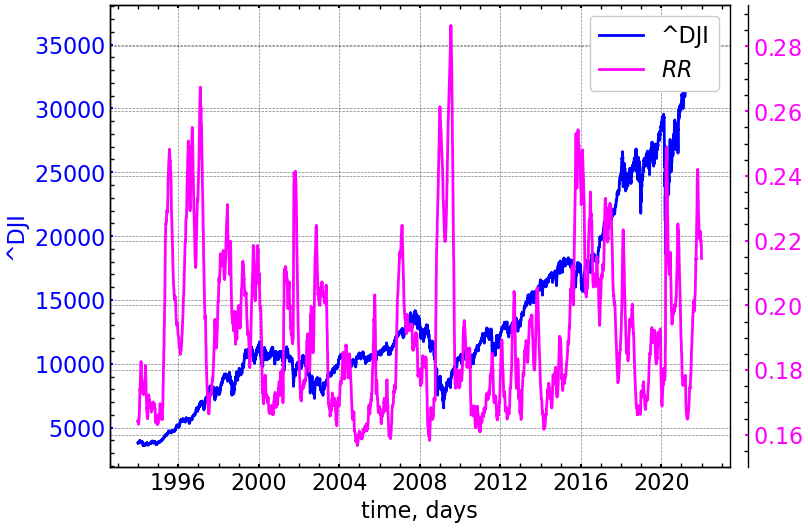

In [15]:
#| label: fig-dji-rr 
#| fig-cap: "Динаміка індексу Доу-Джонса та частоти рекурентності"

plot_recurrence_measure(measure=RR, label='RR')


Як ми можемо бачити з представленого рисунку, міра рекурентності зростає при крахових подіях, що вказує на зростання ступеня самоорганізації та злагодженості торгівельної активності трейдерів на цьому ринку. 

#### Діагональна частота рекурентності (Diagonal recurrence rate)

Даний підхід базується на діагональних рекурентних профілях часового ряду. Діагональний рекурентний профіль кількісно оцінює кількість рекурентних точок на різних лагах, подібно до функції автокореляцій. Для отримання діагонального профілю рекурентностей просто підраховується частка рекурентних точок на діагоналях, розташованих в нижньому правому або нижньому лівому куті рекурентної діаграми, і будується графік як функція відстані від головної діагоналі, тобто лагу.

По іншому можна сказати, що **діагональна частота рекурентності** фіксує величину автокореляції на різних лагах. 

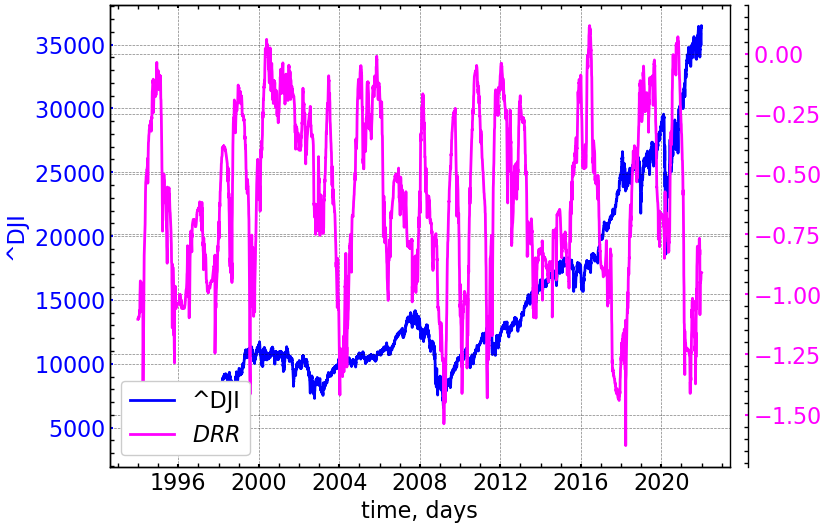

In [16]:
#| label: fig-dji-diag-rr 
#| fig-cap: "Динаміка індексу Доу-Джонса та діагональної частоти рекурентності"

plot_recurrence_measure(measure=DIAG_RR, label='DRR')

З представленого рисунку видно, що діагональна частота рекурентності зростає у передкризові та кризові стани, що вказує на зростання величини автокореляції, що в свою чергу демонструє зростання ступеню самоорганізації у кризові та передкризові стани.  

#### Детермінізм (Determinism)

Наступним показником можна визначити частку рекурентних траєкторій, які формують діагональні лінії мінімальної довжини ${\displaystyle \ell_{\min}}$. Ця міра називається **детермінізмом** і пов'язана з передбачуваністю динамічної системи:

$$
DET=\left. \sum_{\ell=\ell_{\min }}^{N}\ell \cdot P(\ell) \middle/ \sum_{\ell=1}^{N}\ell \cdot P(\ell) \right.,
$$

де $P(\ell )$ --- частотний розподіл довжин $\ell$ діагональних ліній (тобто підраховує кількість діагональних профілів довжини $\ell$).

::: {.callout-tip}
## Додаткова інформація по детермінізму

Детерміновані системи характеризуються значною варіацією діагональних ліній різної довжинию. Періодичні сигнали будуть характеризуватися довгими діагональними лініями, в той час як для хаотичних сигналів діагональні лінії будуть короткими. Для стохастичним систем діагональні лінії взагалі будуть відсутніми, за винятком випадкових закономріностей, що утворюватимуть дуже короткі діагональні лінії. 

Білий шум, наприклад, мав би рекурентну діаграму з майже ізольованими рекурентними точками та дуже малих відсотком діагональних ліній, тоді як детермінований процес демонстрував би дуже малу кількість одиночних рекурентностей, але велику щільність довгих діагональних ліній.

:::

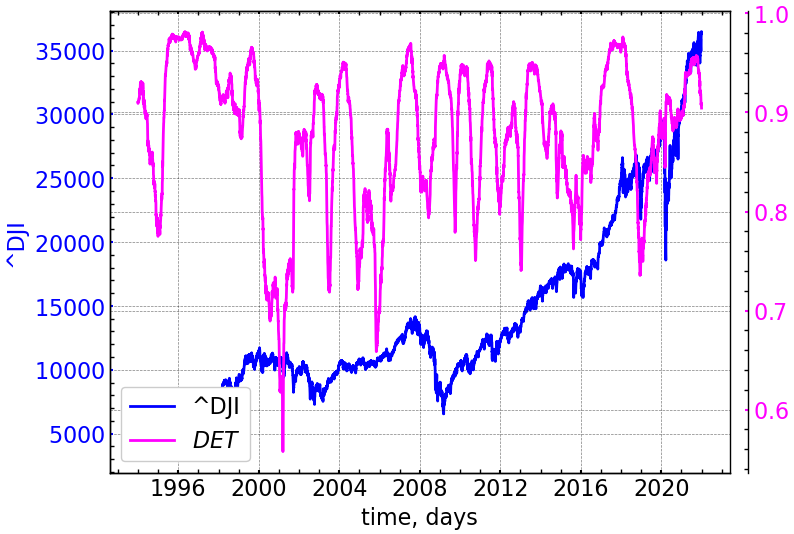

In [17]:
#| label: fig-dji-det 
#| fig-cap: "Динаміка індексу Доу-Джонса та детермінізму"

plot_recurrence_measure(measure=DET, label='DET')

Як ми можемо бачити з представленого рисунку, як правило, у передкризові та кризові стани показник детермінізму починає зростати, що свідчить і про зростання ступеня передбачуваності (впорядкованості) флуктуацій системи.  

#### Ламінарність (Laminarity)

Кількість рекурентних станів, які утворюють вертикальні лінії, можна кількісно визначити таким же чином. Ця міра називається **ламінарністю** і пов'язана з кількістю ламінарних фаз (незмінностей) у системі:

$$
LAM = \left. \sum_{v=v_{\min}}^{N}v \cdot P(v) \middle/ \sum_{v=1}^{N}v \cdot P(v) \right.,
$$

де $P(v)$ --- частотний розподіл довжин $v$ вертикальних ліній, які мають довжину принаймні $v_{\min}$. 

::: {.callout-tip}
## Додаткова інформація по ламінарності

Ламінарність характеризує ймовірність системи перебувати в ламінарному (незмінному) стані. Зі збільшенням ізольованих рекурентних точок у системі, міра ламінарності спадатиме. 

:::

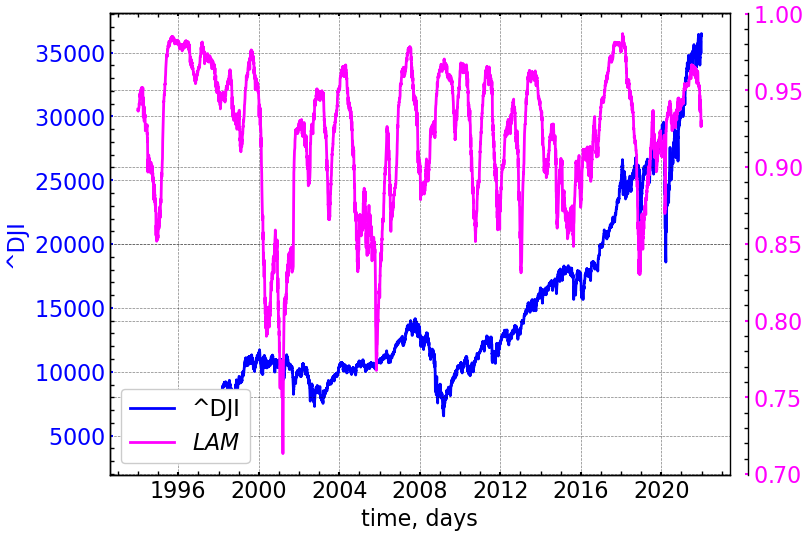

In [18]:
#| label: fig-dji-lam 
#| fig-cap: "Динаміка індексу Доу-Джонса та ламінарності"

plot_recurrence_measure(measure=LAM, label='LAM')

Можна бачити, що при кризових станах ступінь ламінарності зростає. Як ми могли бачити, зростає і щільність діагональних точок, і загалом зростає кількість рекурентних траєкторій у фазовому просторі. Це вказує на те, що фінасовий індекс Доу-Джонса "застрягає" у стані кризи. Кризи характеризуються трендостійкістю, персистентністю та детермінованістю своєї поведінки. 

#### Середня довжина діагональних ліній (Average diagonal lines length)

Також можна виміряти **середню довжину діагональних ліній**. Cередня довжина діагональних лінії визначається як

$$
L = \left. \sum_{{\ell=\ell_{\min}}}^{N}\ell \cdot P(\ell) \middle/ \sum_{{\ell=\ell_{\min}}}^{N}P(\ell) \right..
$$

Загалом цей показник характеризує середній період часу при якому дві траєкторії фазового простору знаходяться в достатній близькості один до одного. 

::: {.callout-tip}
## Додаткова інформація по середній довжині діагональних ліній

Середня довжина діагональних ліній визначає середній час при якому система залишається передбачуваною. 

:::

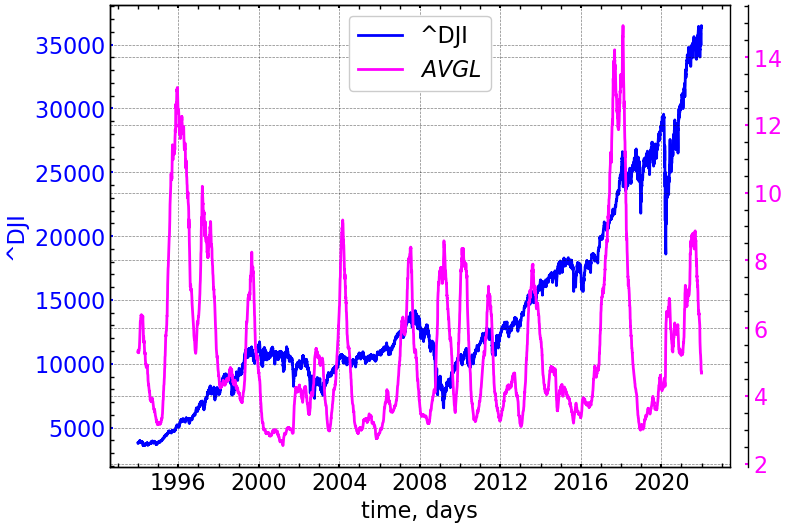

In [19]:
#| label: fig-dji-avgl 
#| fig-cap: "Динаміка індексу Доу-Джонса та середньої довжини діагональних ліній"

plot_recurrence_measure(measure=AVG_DIAG_LINE, label='AVG L')

Як і до цього, ми можемо бачити, що середній час перебування Доу-Джонса у детермінованому стані зростає під час кризових явищ, що говорить зростання ступеня колективізації трейдерів на ринку. 

#### Час захоплення/затримки (Trapping time)

Усереднена довжина діагональної лінії пов'язана з часом передбачуваності динамічної системи та **часом затримки**. У даному випадку індикатором часу затримки в певному стані є **середня довжина вертикальних ліній** або **час захоплення**, що виражається через наступну формулу:

$$
TT = \left. \sum_{{v=v_{\min}}}^{{N}}v \cdot P(v) \middle/ \sum_{{v=v_{\min}}}^{{N}}P(v) \right.. 
$$

::: {.callout-tip}
## Додаткова інформація по середній довжині вертикальних ліній

Середня довжина вертикальних ліній визначає середній час перебування системи в ламінарному стані. Тобто, вона відповідає середньому періоду часу при якому система "завмирає" у певному стані.  Очевидно, що зростання цiєї величини характеризує дедалi бiльший час затримки дослiджуваної системи в
певному станi.

:::

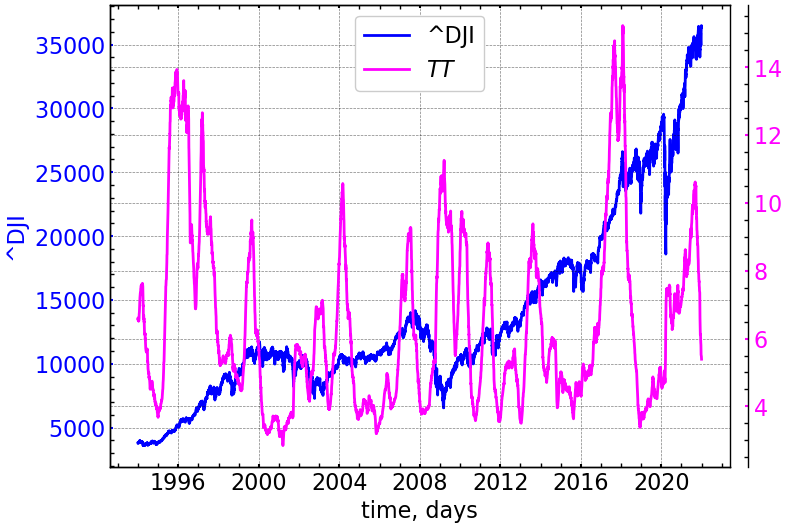

In [20]:
#| label: fig-dji-tt
#| fig-cap: "Динаміка індексу Доу-Джонса та час затримки"

plot_recurrence_measure(measure=TT, label='TT')

На представленому рисунку видно, що $TT$ зростає в (перед-)кризові стани, що вказує на потребу системи перебувати ще більший час у стані кризи. 

#### Середня довжина білих вертикальних лінії (Average white vertical lines length)

**Середня довжина білих вертикальних ліній** може бути визначена як 

$$
WVL_{mean} = \sum_{w=w_{min}}^{N} w \cdot P(w) \Big / \sum_{w=w_{min}}^{N} P(w), 
$$

де $P(w)$ --- це частотний розподіл білих вертикальних ліній довжиною $w$, а $w_{min}$ відповідає найменшій довжині білих вертикальних ліній (найменшому періоду повернення до стану рекурентності).

::: {.callout-tip}
## Додаткова інформація по середній довжині білих вертикальних ліній

Представлену міру можна охарактеризувати як середній горизонт *непередбачуваності* системи.

:::

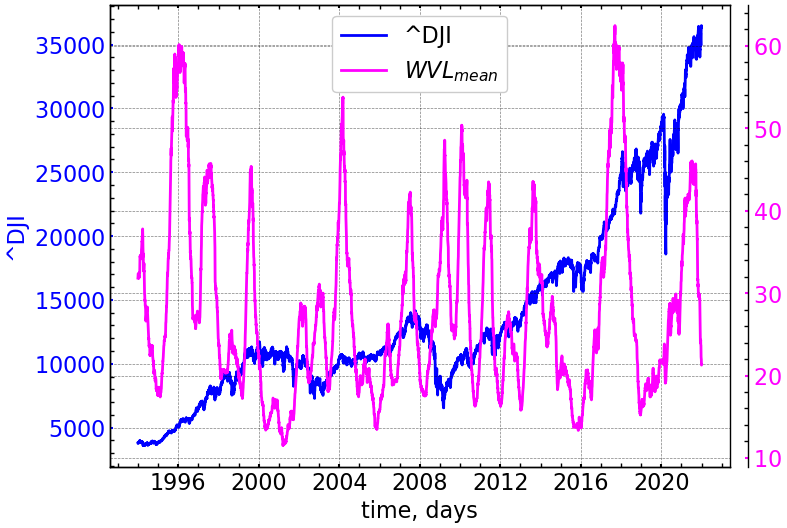

In [21]:
#| label: fig-dji-avgv
#| fig-cap: "Динаміка індексу Доу-Джонса та середньої довжини білих вертикальних ліній"

plot_recurrence_measure(measure=AVG_WVERT_LINE, label='WVL_{mean}')

Зростання середньої довжини бiлих вертикальних лiнiй демонструє, що кризовi подiї характеризуються не лише детермiнiзмом динамiки фондового ринку, але й несхожiстю даних подiй у порiвняннi з попереднiми станами.

#### Ентропія діагональних ліній (Diagonal lines entropy)

Для відповідних діагональних сегментів можна розрахувати необхідну кількість інформації для опису всього розподілу цього типу ліній. Імовірність $p(\ell )$ того, що діагональна лінія має точну довжину $\ell$, можна оцінити за частотним розподілом $P(\ell )$ із $p( \ell ) = \left. P(\ell) \middle/ \sum_{{\ell=\ell_{\min}}}^{N}P(\ell) \right.$. Ентропія Шеннона цієї ймовірності виглядає наступним чином:

$$
DLEn = -\sum_{{\ell =\ell _{\min }}}^{N}p(\ell )\ln p(\ell ). 
$$

Даний показник відображає складність досліджуваної структури.

::: {.callout-tip}
## Додаткова інформація по ентропії діагональних ліній

Для некорельованого шуму чи осциляцiй ми тримали б мале значення цієї ентропiї. Мале значення даної ентропії вказувало б на те, що розподіл діагональних ліній представляється асиметричним: існувала б невеличка частка діагональних ліній конкретної довжини, що характеризувала б усю рекурентність досліджуваної системи. Зростання даної ентропії вказувало б на зростання симетричності розподілу довжин діагональних ліній. 

:::

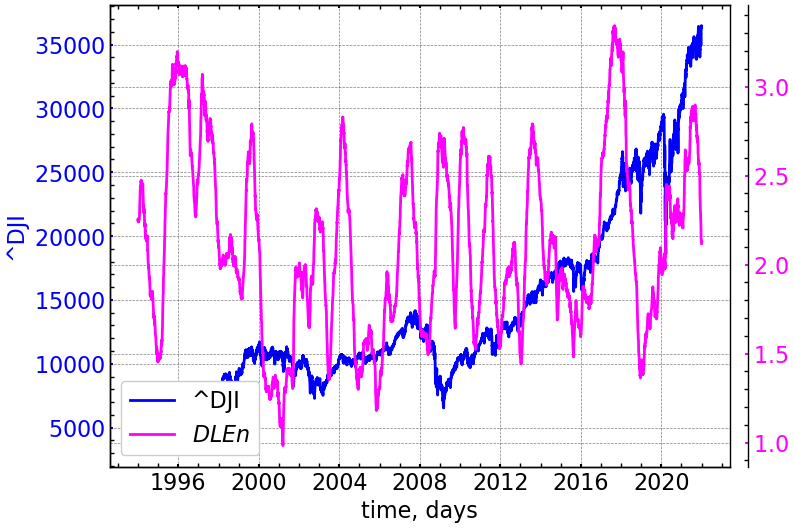

In [22]:
#| label: fig-dji-dlen
#| fig-cap: "Динаміка індексу Доу-Джонса та ентропії діагональних ліній"

plot_recurrence_measure(measure=ENT_DIAG, label='DLEn')

Видно, що ентропія діагональних ліній зростає під час кризових явищ, що вказує на зростання впливу детермінованих процесів із різним ступенем передбачуваності.

#### Ентропія вертикальних ліній (Vertical lines entropy)

Ми можемо визначити Шеннонівську ентропію для розподілу вертикальних структур рекурентної діаграми. Імовірність $p( v )$ того, що вертикальна лінія має точну довжину $v$, можна оцінити за частотним розподілом $P(v)$ із $\left. p(v) = P(v) \middle / \sum_{{v=v_{\min}}}^{N}P(v) \right.$. Ентропія Шеннона цієї ймовірності визначається як

$$
 VLEn =-\sum_{{ v = v_{\min }}}^{N}p( v )\ln p( v ).
$$

Ця міра, по аналогії до попередньої ентропії, також є мірою складності системи. 

::: {.callout-tip}
## Додаткова інформація по ентропії вертикальних ліній

Для синусоїдального процесу ми би очікували мале значення даної ентропії, оскільки це простий періодичний процес. Для складного процесу з пам'ятю ми би очiкуємо високе значення цього типу рекурентної ентропiї. Це означатиме, що ламiнарнiсть процесу характеризуються рiзноманiтними перiодами довгостроковості пам'яті системи. 

:::

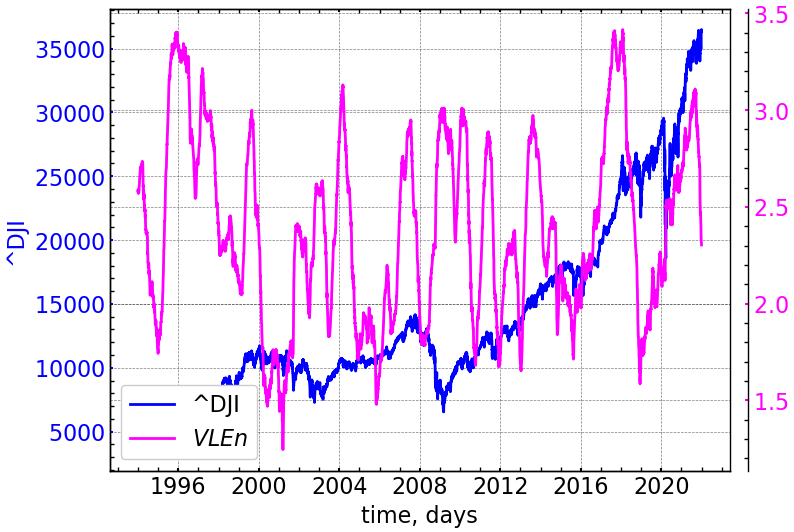

In [23]:
#| label: fig-dji-vlen
#| fig-cap: "Динаміка індексу Доу-Джонса та ентропії вертикальних ліній"

plot_recurrence_measure(measure=ENT_VERT, label='VLEn')

На даному рисунку видно, що ентропія вертикальних ліній починає зростати під час крахових явищ, що вказує на зростання ступеню ламінарності, тобто зростання рівномірності розподілу вертикальних ліній різноманітних довжин. 

#### Дивергенція (Divergence)

Показник $L_{\max }$ може надати нам інформацію про максимальний ступінь передбачуваності досліджуваного періоду. Зворотнє значення **максимальної довжини діагональних ліній** $L_{\max }$ або **дивергенція (розбіжність)** може вказати нам на швидкість та тривалість розбіжності досліджуваних траєкторій. Даний показник можна визначити як

$$ 
\text{DIV} = \left. 1 \middle/ L_{\max} \right.. 
$$

Дана міра схожа на старший показник Ляпунова. Однак взаємозв’язок між цією мірою та позитивним максимальним показником Ляпунова набагато складніший (щоб обчислити показник Ляпунова з RP, необхідно враховувати весь розподіл частот діагональних ліній). Дивергенція може мати тенденцію позитивного максимального показника Ляпунова, але не більше.

::: {.callout-tip}
## Додаткова інформація по дивергенції

Чим вище значення дивергенції, тим швидше розбігаються траєкторії фазового простору. І навпаки, чим нижче значення дивергенції, тим ближче досліджувані траєкторії прилягають один до одного. 

:::

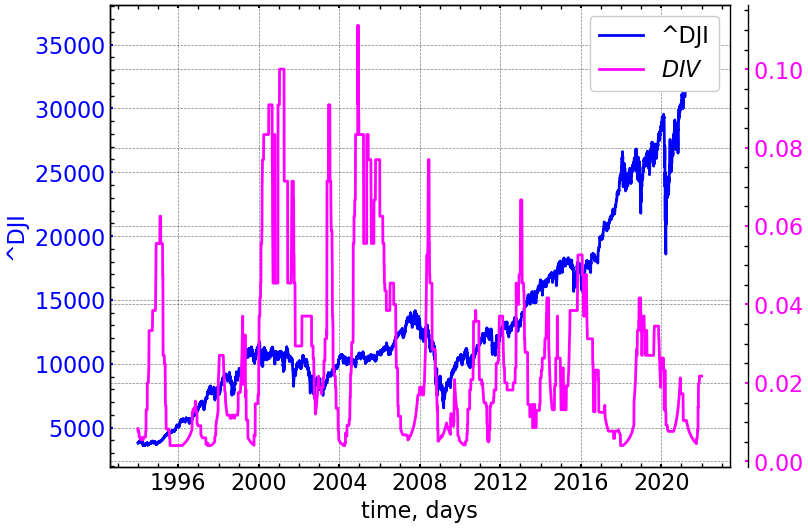

In [24]:
#| label: fig-dji-div
#| fig-cap: "Динаміка індексу Доу-Джонса та дивергенції"

plot_recurrence_measure(measure=DIV, label='DIV')

Даний рисунок показує, що дивергенція діагональних ліній починає спадати в кризові та передкризові періоди, що також вказує на зростання ступеня впорядкованості динаміки системи в дані періоди часу.

#### Дивергенція вертикальних ліній (Vertical line divergence)

Зворотнє значення **максимальної довжини вертикальних ліній** $V_{max}$ або **розбіжність вертикальних ліній** можна визначити як

$$ 
VDIV = 1 / V_{\max}. 
$$

::: {.callout-tip}
## Додаткова інформація по дивергенції вертикальних ліній

Максимальна довижна вертикальних ліній надавала нам інформацію про максимальний ступінь незмінюваності системи. Вертикальна дивергенція дозволяє нам охарактеризувати швидкість настання або спаду ламінарності у системі. Чи вище значення $VDIV$, тим швидше система виходить із ламінарного стану. І навпаки, чим нижчий даний показник, тим ближче траєкторії фазового простору один до одного, і тим вищий ступінь ламінарності системи в конкретний момент часу. 

:::

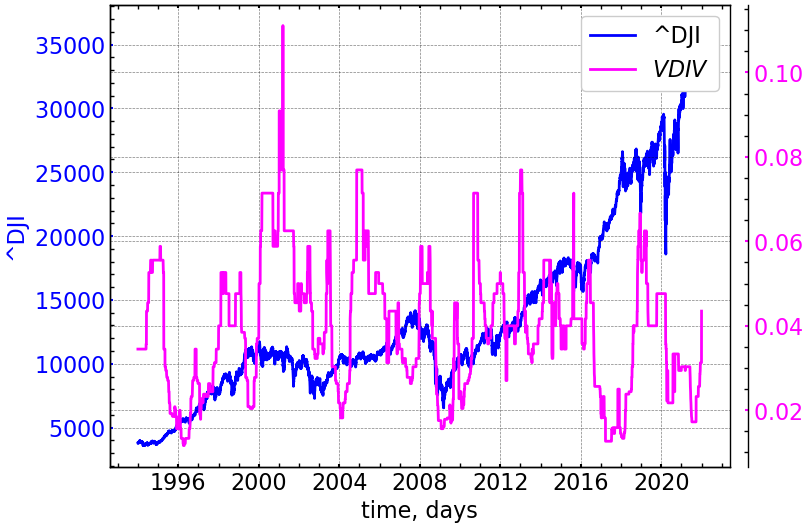

In [25]:
#| label: fig-dji-vdiv
#| fig-cap: "Динаміка індексу Доу-Джонса та дивергенції вертикальних ліній"

plot_recurrence_measure(measure=VERT_DIV, label='VDIV')

На даному рисунку видно, що періоди криз характеризуються спадом вертикальної дивергенції, тобто зростанням кількості вертикальних структур, що характеризують ще більший ступінь ламінарності станів. 

#### Дивергенція білих вертикальних ліній

Зворотнє значення **максимальної довжини білих вертикальних ліній** ($WVL_{max}$) можна охарактеризувати як **дивергенцію білих вертикальних ліній**. Її можна визначити наступним чином:

$$
WVDIV = \left. 1 \middle/ WVL_{max} \right.. 
$$

Зростання даного показника має вказувати на зростання ступеня рекурентності системи, а його спад має демонструвати зростання непередбачуваності. 

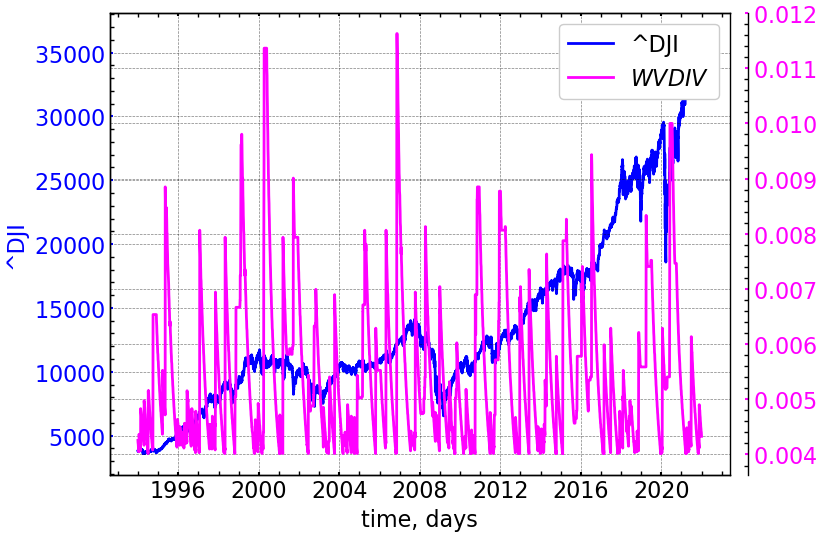

In [26]:
#| label: fig-dji-wvdiv
#| fig-cap: "Динаміка індексу Доу-Джонса та дивергенції білих вертикальних ліній"

plot_recurrence_measure(measure=WHITE_VERT_DIV, label='WVDIV')

На даному рисунку видно, що дивергенція білих вертикальних ліній представляє доволі зашумлену динаміку, а тому не може бути використана в якості ефективного індикатора кризових явищ. 

#### Ентропія білих вертикальних ліній (White vertical lines entropy)

Імовірність $p( \omega )$ того, що біла вертикальна лінія має точну довжину $\omega$, можна оцінити за частотним розподілом $P(\omega)$ із $p(\omega) = \left. P(\omega) \middle/ \sum_{{\omega=\omega_{\min}}}^{N} P(\omega) \right.$. Ентропія Шеннона цієї ймовірності,

$$
{\text{WVertEn}}=-\sum_{{\omega =\omega _{\min }}}^{N}p(\omega )\ln p(\omega ),
$$

де $\omega_{min}$ --- мінімальна довжина білої вертикальної лінії. 

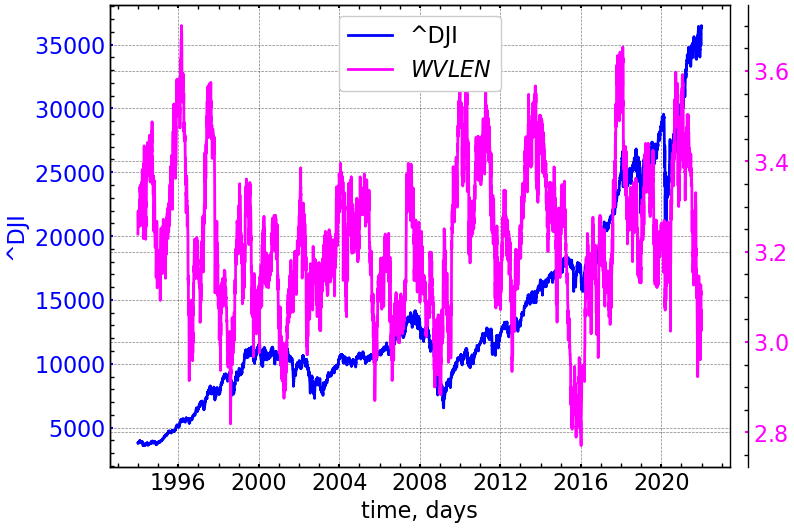

In [27]:
#| label: fig-dji-wvlen
#| fig-cap: "Динаміка індексу Доу-Джонса та ентропії білих вертикальних ліній"

plot_recurrence_measure(measure=ENT_WHITE_VERT, label='WVLEN')

Видно, що ентропія білих вертикальних ліній спадає у кризові та передкризові періоди фондового ринку, що вказує на зростання загальної передбачуваності системи та зміщення розподілу білих вертикальних ліній до конкретних довжин. Тобто, їх розподіл у періоди криз стає менш симетричним, що вказує на поступове заміщення білих вертикальних ліній чорними. 

#### Співвідношення частоти рекурентності до детермінізму $DET/RR$

Співвідношення між $DET$ і $RR$ ($RATIO$) можна використовувати для виявлення прихованих фазових переходів у системи:

$$
RATIO_1 = \left. DET \middle/ RR = N^2 \cdot \left( \sum_{l=l_{min}}^{N}l \cdot P(l) \right) \middle/ \left(\sum_{l=1}^{N}lP(l)\right)^2 \right..
$$

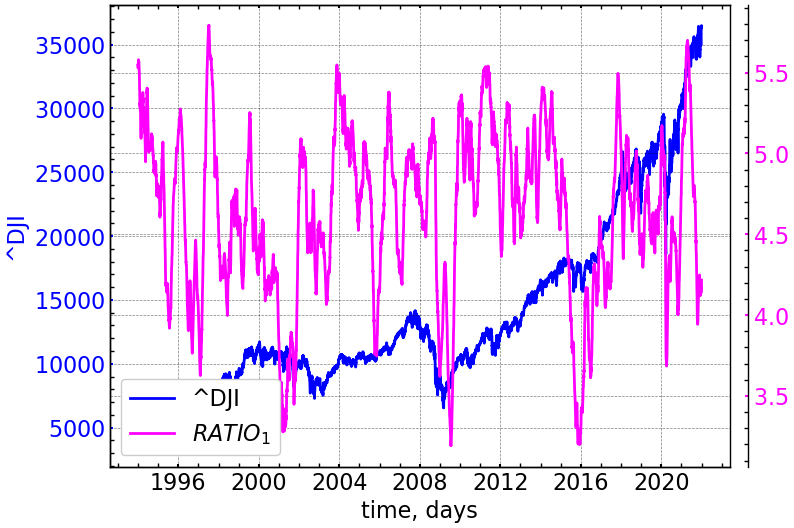

In [28]:
#| label: fig-dji-det_rr
#| fig-cap: "Динаміка індексу Доу-Джонса та співвідношення 
#| між мірою передбачуваності та рекурентності"

plot_recurrence_measure(measure=RATIO_DET_REC, label='RATIO_1')

Даний показник спадає під час кризових явищ фондового ринку. Це говорить про те, що має зростати загальна щільність рекурентних точок, як ізольованих, так і просто розподілу вертикальних структур. Тобто, у кризові періоди $RR$ представляється вищою за $DET$. 

#### Співвідношення ламінарності до детермінізму (LAM/DET)

Так само як і попередня міра, відношення ламінарності до детермінізму може дозволити нам виокремити приховані переходи в досліджуваному сигналі:

$$
RATIO_2 = \left. LAM \middle/ DET \right..
$$

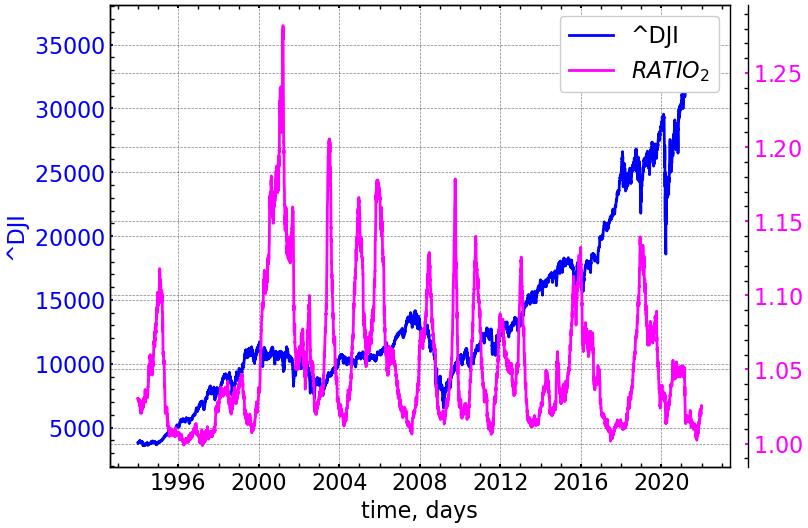

In [29]:
#| label: fig-dji-lam_det
#| fig-cap: "Динаміка індексу Доу-Джонса та співвідношення 
#| між мірою ламінарності та детермінізмом"

plot_recurrence_measure(measure=RATIO_LAM_DET, label='RATIO_2')

Якщо виходити з динаміки показника $RATIO_2$, можна сказати, що загальний ступінь детермінізму починає переважати над ламінарністю під час кризових явищ. 

Але по результатам представлених показників ми можемо сказати, що досліджувані крахові та передкрахові події характеризуються зростанням рекурентності, і подібного роду поведінка може бути використана в якості передвісника подальших криз.

## Завдання для самостійної роботи

1. Виберіть за рекомендацією викладача свій варіант часового ряду
2. Проведіть дослідження динаміки кількісних мір рекурентності згідно інструкції
3. Зробити висновки